
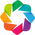

Loading BokehJS ...

In [1]:
import numpy as np
import pandas as pd

import holoviews as hv
hv.extension("bokeh")

from matplotlib import pyplot as plt
import matplotlib as mpl

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()

## Declaring data

For presentation purposes, the dummy data contains time series data with frequency patterns which nicely shows the benefit of radial heatmaps to detect periodicities.

Generate hourly values for 31 days with 7 days a week. A segement represents an hour whereas an annular represents an entire day. 

In [69]:
days = 31
hours = 24

size = days*hours

def generate_hourly_periodic_data(x):
    periodic_weekly = np.sin(x*2*np.pi / (24*7))
    periodic_daily = np.sin(x*2*np.pi / 24)
    noise = np.random.random(size=x.size)
    
    return periodic_weekly + periodic_daily + noise

x = np.linspace(0, size, size)
y = generate_hourly_periodic_data(x)

date_index = pd.date_range(start="2017-10-01", freq="h", periods=size)
kdim_segment = date_index.strftime("%H:%M")
kdim_annular = date_index.strftime("%A %d")

df = pd.DataFrame({"values": y, "hour": kdim_segment, "day": kdim_annular}, index=date_index)
df.head()

,day,hour,values
2017-10-01 00:00:00,Sunday 01,00:00,0.472580
2017-10-01 01:00:00,Sunday 01,01:00,1.283191
2017-10-01 02:00:00,Sunday 01,02:00,1.128412
2017-10-01 03:00:00,Sunday 01,03:00,1.142576
2017-10-01 04:00:00,Sunday 01,04:00,1.119750


In [70]:
df_week = df["values"].resample("4h").mean().to_frame()
df_week["day"] = df_week.index.strftime("%A %H")
df_week["week"] = df_week.index.strftime("Week %W")
df_week.head()

,values,day,week
2017-10-01 00:00:00,1.006689,Sunday 00,Week 39
2017-10-01 04:00:00,1.420731,Sunday 04,Week 39
2017-10-01 08:00:00,1.619013,Sunday 08,Week 39
2017-10-01 12:00:00,0.735187,Sunday 12,Week 39
2017-10-01 16:00:00,0.125233,Sunday 16,Week 39


In [71]:
%%opts Curve [width=700, tools=["hover"]]
hv.Curve((date_index, y), label="Naive time series")

:Curve   [x]   (y)

### Helper functions

In [60]:
def _compute_bins(start, end, count, start_offset=0, end_offset=0):
    """Compute interval boundaries for given range defined by 
    `start` and `end` with given interval `count`.
    
    For example, for a range from 0 to 3 with 3 bins, create:
    [[0, 1],
     [1, 2],
     [2, 3]]
    
    """
    
    bounds = np.linspace(start, end, count + 1)
    edges = np.vstack([bounds[:-1] + start_offset, bounds[1:] + end_offset]).T
    
    return edges


def _extract_implicit_order(array):
    """Iterate given array and extract unique values in
    existing order.
    
    """
    
    order = []
    contained = set()
    
    for element in array:
        if not element in contained:
            order.append(element)
            contained.update([element])
    
    return order


def _map_order_to_bins(start, end, order, reverse=False):
    """Helper function to map elements from given `order` array
    to bins ranging from `start` to `end`.
    
    """
    
    size = len(order)
    bins = _compute_bins(start, end, size)
    
    if reverse:
        bins = bins[::-1]
    
    mapping = dict(zip(order, bins))
    
    return mapping


def _extract_bounds_via_mapping(mapper, values):
    """Helper function to extract first and second value
    from tuples of mapped bins.
    
    """
    
    tuples = [mapper.get(x) for x in values]
    start, end = zip(*tuples)
    
    return np.array(start), np.array(end)


def _extract_segment_text_radiant(mapper):
    """Extracts text label and radiant for segement texts.
    
    """
    
    values = [(text, ((end-start)/2) + start)
              for text, (start, end) in mapper.items()]
    
    text, radiants = zip(*values)
    
    return text, np.array(radiants)
    
    
    
def _mpl_to_bokeh_color(values, cmap):
    """Helper function to convert mpl color to bokeh color.
    
    
    """
    
    cmap = plt.get_cmap(cmap)
    normed = mpl.colors.Normalize()(values)
    colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) 
              for r, g, b, _ in 255*cmap(normed)]
    
    return colors


def _compute_segment_marker_lines(inner, outer, angles):
    """Compute x and y positions for segment marker.
    
    """

    y_start = np.sin(angles) * inner
    y_end = np.sin(angles) * outer
    
    x_start = np.cos(angles) * inner
    x_end = np.cos(angles) * outer
    
    return list(zip(x_start, x_end)), list(zip(y_start, y_end))

In [65]:
def radial_heatmap(df, dim_segment, dim_annular, dim_values, 
                   inner=0.1, angle=np.pi/2, dim_color=None, cmap="viridis",
                   order_segment=None, order_annular=None, size=800, 
                   segment_label_nth=None):
    
    # get orders
    if not order_segment:
        order_segment = _extract_implicit_order(df[dim_segment])
    
    if not order_annular:
        order_annular = _extract_implicit_order(df[dim_annular])
    
    # get colors
    if dim_color:
        color = dim_color.values
    else:
        color = _mpl_to_bokeh_color(df[dim_values].values, cmap)
        
    # get radiants and radius
    radius_max = 1000    
    
    mapping_annular = _map_order_to_bins(radius_max*inner, radius_max, order_annular)
    mapping_segment = _map_order_to_bins(angle, angle + 2*np.pi, order_segment, True)
        
    radiants_start, radiants_end = _extract_bounds_via_mapping(mapping_segment, df[dim_segment])
    radius_start, radius_end = _extract_bounds_via_mapping(mapping_annular, df[dim_annular])

    annular_source = ColumnDataSource(dict(
                               radiants_start=radiants_start,
                               radiants_end=radiants_end,
                               radius_start=radius_start,
                               radius_end=radius_end,
                               color=color,
                               segment=df[dim_segment].values,
                               annular=df[dim_annular].values,
                               value=df[dim_values].values))

    
    # get x and y coords for text
    if segment_label_nth:
        text_mapping = {x: mapping_segment[x] 
                        for x in order_segment[::segment_label_nth]}
    else:
        text_mapping = {x: mapping_segment[x] for x in order_segment}
    
    text_labels, text_radiant = _extract_segment_text_radiant(text_mapping)
    text_y_coord = np.sin(text_radiant) * radius_max * 1.01
    text_x_coord = np.cos(text_radiant) * radius_max * 1.01

    text_source = ColumnDataSource(dict(x=text_x_coord, 
                                        y=text_y_coord, 
                                        text=text_labels,
                                        angle=1.5*np.pi+text_radiant))
    
    
    # get segment marker
    angles = np.array(list(text_mapping.values()))[:, 1]
    xs, ys = _compute_segment_marker_lines(radius_max*inner, radius_max, angles)
    marker_source = ColumnDataSource(dict(xs=xs, ys=ys))
    
    
    # setup figure
    p = figure(plot_width=size, plot_height=size, match_aspect=True)
    
    radial_glyphes = p.annular_wedge(
                x=0, y=0, 
                inner_radius="radius_start", outer_radius="radius_end", 
                start_angle="radiants_start", end_angle="radiants_end",
                fill_color="color", line_color="#FFFFFF", 
                hover_line_color="#000000", hover_fill_color="color",
                source=annular_source)
    
    p.text(x="x", y="y", 
           text="text", angle="angle", 
           text_align="center", source=text_source)
    
    if segment_label_nth:
        p.multi_line(xs="xs", ys="ys", source=marker_source, 
                     line_width=3.5, line_color="#FFFFFF")

    p.grid.visible = False
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.outline_line_color = None
    
    hover = HoverTool(tooltips=[("Segment", "@segment"),
                                ("Annular", "@annular"),
                                ("Value", "@value")], renderers=[radial_glyphes])
    
    p.add_tools(hover)
    
    
    show(p)

## Plot

In [66]:
radial_heatmap(df, "hour", "day", "values", size=900, segment_label_nth=None)

In [67]:
radial_heatmap(df, "hour", "day", "values", size=900, segment_label_nth=4)

In [68]:
radial_heatmap(df_week, "day", "week", "values", size=800, segment_label_nth=6)